In [ ]:
import numpy as np
import obspy
from obspy import taup as tp
import os
from rfpy import RFData
from rfpy import HkStack
from rfpy.binning import bin
from matplotlib import pyplot as plt
import pickle
from obspy import UTCDateTime

In [ ]:
#loading Q3 rf data
rf_paths = open("DB/04_paths_quality_3.txt", "r").readlines()
rf_paths = [x.split("RFR")[0] for x in rf_paths]     #remove file name

H_list = np.linspace(15, 40, 100)
k_list = np.linspace(1.1, 3.1, 100)
vp = 6.5
t_Ps_all = []




for rf in rf_paths:
    tr = obspy.read(f"{rf}RFR.sac")
    info_dict = pickle.load(open(f"{rf}info_dic.pkl", "rb"))
    P = info_dict["slow"]
    k, H = np.meshgrid(k_list, H_list)
    vs = vp/k
    cVs = np.sqrt((1/vs**2)-P**2)  #a common term in all formulas
    cVp = np.sqrt((1/vp**2)-P**2)  #a common term in all formulas
    tPs = H * (cVs - cVp)
    
    t_Ps_all.append(tPs)

In [ ]:
#loading Q3 rf data
rf_paths = open("DB/04_paths_quality_3.txt", "r").readlines()
rf_paths = [x.split("RFR")[0] for x in rf_paths]     #remove file name

st = obspy.Stream()
for counter, rf in enumerate(rf_paths):
    path = rf + "RFR.sac"
    tr = obspy.read(path)[0]#.data
    # plt.plot(tr+counter*0.05, 'k')
    # plt.xlim(100,400)
    tr.stats.distance = tr.stats.sac.gcarc * 111.19
    tr.stats.starttime = UTCDateTime(0)
    st += tr
t1 = UTCDateTime(0) + 40
t2 = UTCDateTime(0) + 400
st.trim(t1,t2)    
st.plot(type='section' , scale = 20.0, fillcolors=('r','b'), recordlength=25, orientation="horizontal")

st = obspy.Stream()
for rf in rf_paths:
    path = rf + "RFR.sac"
    tr = obspy.read(path)[0]
    st += tr
test = st.stack().plot()
plt.show()

In [102]:
rf_paths = open("DB/04_paths_quality_3.txt", "r").readlines()
rf_paths = [x.split("/RFR")[0] for x in rf_paths]     #remove file name
inventory = obspy.read_inventory("DB/inventory*.xml")
st = obspy.Stream()

for path in rf_paths:
    waveforms = obspy.read(f"{path}/raw*.sac")
    network, station = path.split("/")[1].split("_")
    inv = inventory.select(network= network, station= station)
    ev = obspy.read_events(f"{path}/event.xml")[0]
    rfdata = RFData(inv[0][0])
    rfdata.add_event(ev, returned=True)
    rfdata.add_data(waveforms)
    rfdata.rotate(align="ZRT")
    rfdata.calc_snr()
    rfdata.deconvolve()
    st += rfdata.to_stream()



In [156]:
rfstream1 = st
rfstream2 = st.copy()
rfstream1.filter('bandpass', freqmin=0.05, freqmax=0.5, corners=2, zerophase=True)
rfstream2.filter('bandpass', freqmin=0.05, freqmax=0.35, corners=2, zerophase=True)
hkstack = HkStack(rfstream1, rfstream2)
hkstack.vp = 6.5
hkstack.stack()

Computing: [###############] 61/61


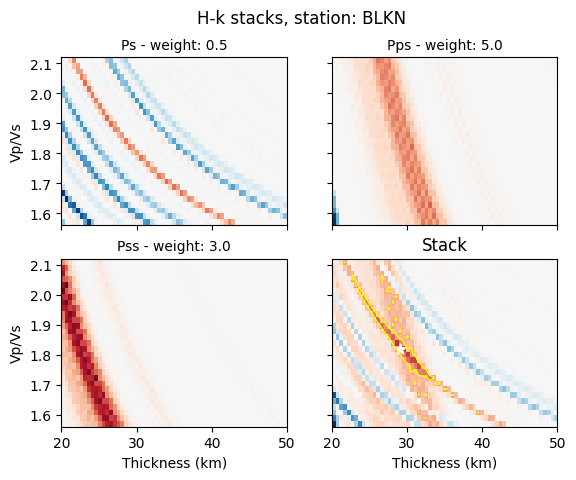

In [152]:
hkstack.weights = [0.5, 5, 3]
hkstack.average()
hkstack.plot()

In [140]:
#saving results
dict = {"vp": hkstack.vp, "weights": hkstack.weights, "h0":hkstack.h0, "k0": hkstack.k0, "h0_error": hkstack.err_h0 ,"k0_error": hkstack.err_k0}
with open (f"results/hk_{rfstream1[0].stats.station}_vp_{dict['vp']}_Ps-weight_{dict['weights'][0]}.pkl", "wb") as pickle_file:
    pickle.dump(dict,pickle_file)
print(dict)
print(f"file 'hk_{rfstream1[0].stats.station}_vp_{dict['vp']}_Ps-weight_{dict['weights'][0]}.pkl' saved.")

{'vp': 5.5, 'weights': [0.5, 5, 1], 'h0': 29.0, 'k0': 1.8200000000000003, 'h0_error': 5.25, 'k0_error': 0.14000000000000012}
file 'hk_BLKN_vp_5.5_Ps-weight_0.5.pkl' saved.


ImportError: cannot import name 'HkStack1' from 'rfpy' (/opt/anaconda3/envs/rfpy/lib/python3.9/site-packages/rfpy/__init__.py)